In [8]:
import io, requests

import pandas as pd

URL_TEMPLATE = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_%s_global.csv'
def url2df(url,typ):
    content = requests.get(url%typ).content
    df = pd.read_csv(io.StringIO(content.decode('utf-8')))
    print((typ,df.shape))
    return df
typ2df = dict((typ,url2df(URL_TEMPLATE,typ)) for typ in ['confirmed','deaths','recovered'])
typ2df['deaths'].sample(3)

('confirmed', (253, 72))
('deaths', (253, 72))
('recovered', (239, 72))


,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20
123,NaN,Guatemala,15.7835,-90.2308,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
160,NaN,Monaco,43.7333,7.4167,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
230,NaN,Zimbabwe,-20.0000,30.0000,0,0,0,0,0,0,...,0,0,0,1,1,1,1,1,1,1


In [33]:
KVS_ID = {
  'Country/Region':'nation',
  'Province/State':'state',
  'Lat':'lat',
  'Long':'lon',
  }
def r2c(df,groupby_nation=True):
  df = (df
    .rename(columns=KVS_ID)
    .drop(['lat','lon'],axis='columns')
     )
  if groupby_nation:
    return (df
      .drop('state',axis='columns')
      .groupby('nation')
      .agg(sum)
      .T
      )
  else:
    return (df
      .set_index(['nation','state'])
      .T
      )

nations = ['China'
  ,'Italy','US'
  ,'United Kingdom', 'Sweden',
#   ,'Spain','France','Germany'
  ]
df_cases = r2c(typ2df['confirmed'])[nations]
df_deaths = r2c(typ2df['deaths'])[nations]
df_recover = r2c(typ2df['recovered'])[nations]
df_out = df_deaths + df_recover
df_d_deaths = df_deaths-df_deaths.shift(1)
print(df_cases.tail(21))
print(df_out.tail(3))
print(df_d_deaths.tail(3))

nation   China  Italy      US  United Kingdom  Sweden
3/9/20   80860   9172     583             322     248
3/10/20  80887  10149     959             384     355
3/11/20  80921  12462    1281             459     500
3/12/20  80932  12462    1663             459     599
3/13/20  80945  17660    2179             802     814
3/14/20  80977  21157    2727            1144     961
3/15/20  81003  24747    3499            1145    1022
3/16/20  81033  27980    4632            1551    1103
3/17/20  81058  31506    6421            1960    1190
3/18/20  81102  35713    7783            2642    1279
3/19/20  81156  41035   13677            2716    1439
3/20/20  81250  47021   19100            4014    1639
3/21/20  81305  53578   25489            5067    1763
3/22/20  81435  59138   33276            5745    1934
3/23/20  81498  63927   43847            6726    2046
3/24/20  81591  69176   53740            8164    2286
3/25/20  81661  74386   65778            9640    2526
3/26/20  81782  80589   8383

In [3]:
import matplotlib.pyplot as plt

def plot(df,title=''):
  plt.figure()
  df.index = pd.to_datetime(df.index)
  y_max = max(df.fillna(0.).max(axis=1)) * 1.1
  df.plot(
    figsize=(12,8),
    title=title,
    ylim=(0, y_max),
    xlim=(df.index[0], df.index[-1]),
    )
  plt.show()
plot(df_deaths,'Deaths: Cumulative')
df_d_deaths = df_deaths - df_deaths.shift(1)
plot(df_d_deaths,'Deaths: Daily')

<Figure size 640x480 with 0 Axes>

<Figure size 1200x800 with 1 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 1200x800 with 1 Axes>

<Figure size 432x288 with 0 Axes>

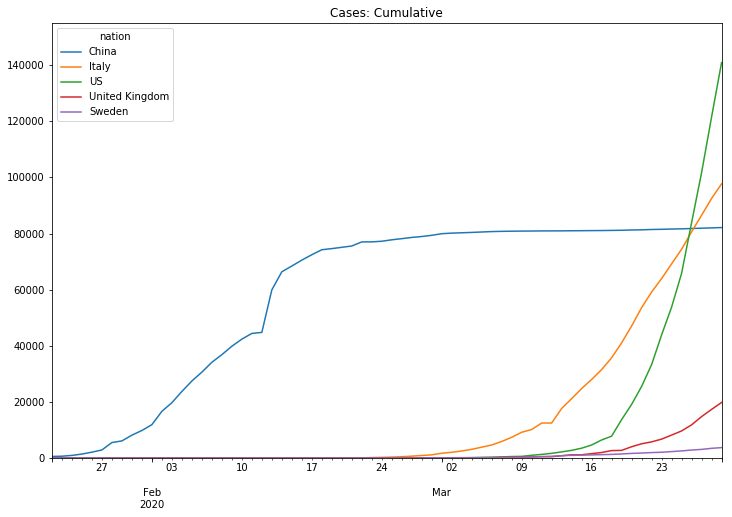

<Figure size 432x288 with 0 Axes>

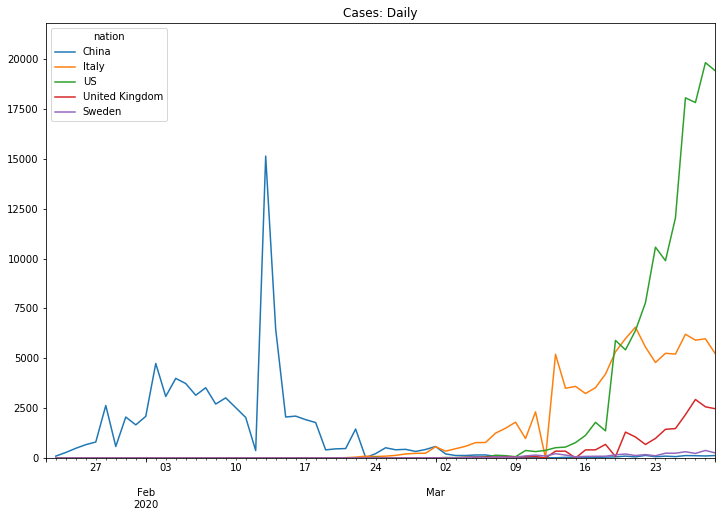

In [13]:
plot(df_cases,'Cases: Cumulative')
df_d_cases = df_cases - df_cases.shift(1)
plot(df_d_cases,'Cases: Daily')

nation   China  Italy    US  United Kingdom  Sweden  China  Italy      US  \
3/25/20   3285   7503   942             466      62  81661  74386   65778   
3/26/20   3291   8215  1209             580      77  81782  80589   83836   
3/27/20   3296   9134  1581             761     105  81897  86498  101657   
3/28/20   3299  10023  2026            1021     105  81999  92472  121478   
3/29/20   3304  10779  2467            1231     110  82122  97689  140886   

nation   United Kingdom  Sweden  
3/25/20            9640    2526  
3/26/20           11812    2840  
3/27/20           14745    3069  
3/28/20           17312    3447  
3/29/20           19780    3700  
nation      China     Italy        US  United Kingdom    Sweden
3/25/20  0.040227  0.100866  0.014321        0.048340  0.024545
3/26/20  0.040241  0.101937  0.014421        0.049103  0.027113
3/27/20  0.040246  0.105598  0.015552        0.051611  0.034213
3/28/20  0.040232  0.108390  0.016678        0.058976  0.030461
3/29/20  0.04

<Figure size 432x288 with 0 Axes>

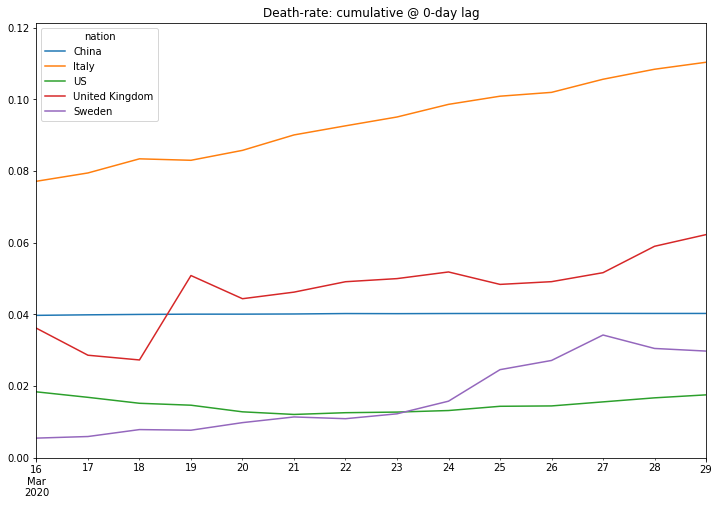

In [14]:
# Death-rate from cumulative w/ 0-day lag
T = 0
print(pd.concat([df_deaths, df_cases.shift(T)], axis='columns').tail(5))
df_rate_death = df_deaths / df_cases.shift(T)
print(df_rate_death.tail(5))
plot(df_rate_death.tail(14),'Death-rate: cumulative @ %s-day lag'%T)

nation   China  Italy    US  United Kingdom  Sweden    China    Italy      US  \
3/25/20   3285   7503   942             466      62  80921.0  12462.0  1281.0   
3/26/20   3291   8215  1209             580      77  80932.0  12462.0  1663.0   
3/27/20   3296   9134  1581             761     105  80945.0  17660.0  2179.0   
3/28/20   3299  10023  2026            1021     105  80977.0  21157.0  2727.0   
3/29/20   3304  10779  2467            1231     110  81003.0  24747.0  3499.0   

nation   United Kingdom  Sweden  
3/25/20           459.0   500.0  
3/26/20           459.0   599.0  
3/27/20           802.0   814.0  
3/28/20          1144.0   961.0  
3/29/20          1145.0  1022.0  
nation      China     Italy        US  United Kingdom    Sweden
3/25/20  0.040595  0.602070  0.735363        1.015251  0.124000
3/26/20  0.040664  0.659204  0.726999        1.263617  0.128548
3/27/20  0.040719  0.517214  0.725562        0.948878  0.128993
3/28/20  0.040740  0.473744  0.742941        0.892483

<Figure size 432x288 with 0 Axes>

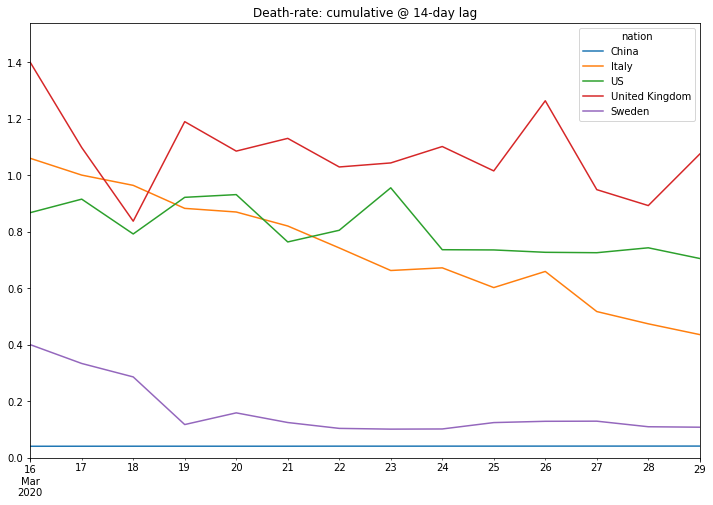

In [18]:
# Death-rate from cumulative w/ T-day lag
T = 14
print(pd.concat([df_deaths, df_cases.shift(T)], axis='columns').tail(5))
df_rate_death = df_deaths / df_cases.shift(T)
print(df_rate_death.tail(5))
plot(df_rate_death.tail(14),'Death-rate: cumulative @ %s-day lag'%T)

nation      China  Italy     US  United Kingdom  Sweden  China   Italy  \
2020-03-25    4.0  683.0  236.0            43.0    26.0   44.0  4207.0   
2020-03-26    6.0  712.0  267.0           114.0    15.0   54.0  5322.0   
2020-03-27    5.0  919.0  372.0           181.0    28.0   94.0  5986.0   
2020-03-28    3.0  889.0  445.0           260.0     0.0   55.0  6557.0   
2020-03-29    5.0  756.0  441.0           210.0     5.0  130.0  5560.0   

nation          US  United Kingdom  Sweden  
2020-03-25  1362.0           682.0    89.0  
2020-03-26  5894.0            74.0   160.0  
2020-03-27  5423.0          1298.0   200.0  
2020-03-28  6389.0          1053.0   124.0  
2020-03-29  7787.0           678.0   171.0  
nation         China       Italy          US  United Kingdom     Sweden  \
2020-03-25  3.666667  675.666667  175.000000       61.333333  13.666667   
2020-03-26  5.666667  712.666667  217.333333       81.333333  17.333333   
2020-03-27  5.000000  771.333333  291.666667      112.666667

<Figure size 432x288 with 0 Axes>

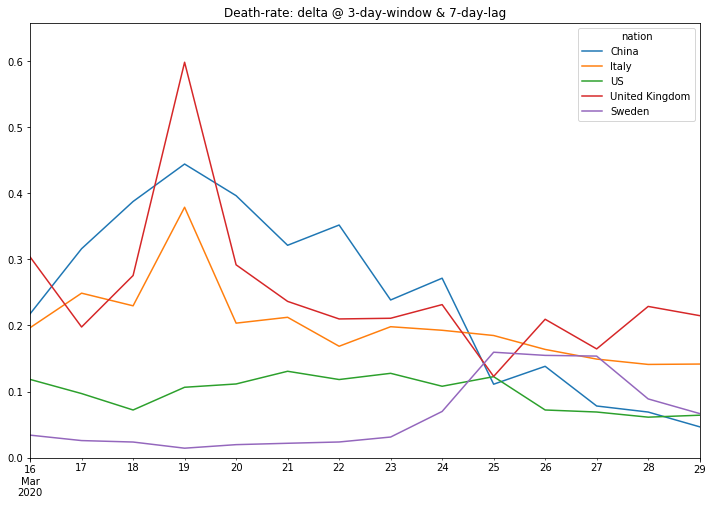

In [29]:
# Death-rate from delta w/ T-day lag
T = 7
W = 3
print(pd.concat([df_d_deaths, df_d_cases.shift(T)], axis='columns').tail(5))
print(pd.concat([df_d_deaths.rolling(W).mean(), df_d_cases.shift(T).rolling(W).mean()], axis='columns').tail(5))
df_rate_death = df_d_deaths.rolling(W).mean() / df_d_cases.shift(T).rolling(W).mean()
print(df_rate_death.tail(5))
plot(df_rate_death.tail(14),'Death-rate: delta @ %s-day-window & %s-day-lag'%(W,T))